In [1]:
import pandas as pd

df = pd.read_csv("../data/RUN000054_data.txt")


In [2]:
df[df["HEAD"]==0]

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS


In [3]:
df.reset_index()

,index,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,0,2,0,35,1379482729,2693,11
1,1,2,0,56,1379482738,3051,1
2,2,2,1,122,1379482739,567,12
3,3,2,0,98,1379482743,3196,23
4,4,2,0,101,1379482743,3201,13
...,...,...,...,...,...,...,...
3404022,3404022,2,0,70,1400040308,1378,3
3404023,3404023,2,0,18,1400040308,1383,21
3404024,3404024,2,0,75,1400040308,1383,6
3404025,3404025,2,0,20,1400040308,1380,27


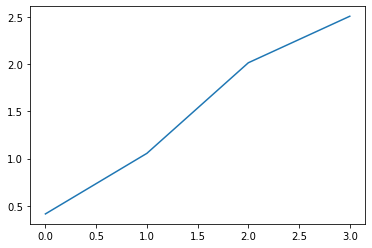

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats

X = np.arange(0, 4, 1)
Y = X + np.random.rand(4)-0.5

plt.plot(X, Y)

def f(X, a, b):
    return a + b*X

sigma_X = [0.4]*4
p_init = [0, 1]  # valori iniziali

import timeit

opt = timeit.timeit("optimize.curve_fit(f, X, Y, sigma=sigma_X, p0=p_init)", globals=globals(), number=100)
linregr = timeit.timeit("stats.linregress(X, Y)", globals=globals(), number=100)

In [5]:
print(opt, linregr)

0.01878380800008017 0.017465334000007715


In [8]:
import pandas as pd
import numpy as np
import yaml
import math
import warnings
import argparse
import sys
import timeit

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")


from eventsFactory import getEvents
from reco import getRecoResults

"""USAGE:

    python dataset_script.py -i <input_data_directory> -o <output_data_directory> -c <config_directory> -run <last_4_digits_of_run>
    
    The I/O directories should be ../data/ (as default)
    
    The configuration directories should be ../config/ (as default)
    
    NOTE that data and config files should be named accordingly
    
    EXAMPLE: 
    
    python dataset_script.py -run 0054 
    
"""

# CONSTANTS
USE_TRIGGER = False
RUN_TIME_SHIFT = 0
KEEP = ["FPGA", "TDC_CHANNEL", "HIT_DRIFT_TIME", "m"]


def argParser():
    """manages command line arguments"""

    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-i", "--input", type=str, default="../data/", help="input data directory"
    )
    parser.add_argument(
        "-o", "--output", type=str, default="../data/", help="output data directory"
    )
    parser.add_argument(
        "-c", "--config", type=str, default="../config/", help="config directory"
    )
    parser.add_argument("-run", "--run", type=str, default="0054", help="run number")

    return parser.parse_args()


def buildDataframe(stream_df, cfg):

    df = pd.DataFrame()

    # reco (da sistemare getEvents e getRecoResults)
    print("Getting events...")
    events = getEvents(stream_df, cfg, RUN_TIME_SHIFT, USE_TRIGGER)
    print("Reconstructing tracks...")
    resultsList, resultsData, resultsHits, resultsDf = getRecoResults(events, USE_TRIGGER)
    reco_time = timeit.timeit("getRecoResults(events, USE_TRIGGER)", globals=dict(locals(), **globals()), number = 1)
    print("Building dataframe...")
    # out df
    for df_ in resultsDf:
        df_ = df_[KEEP]
        df = pd.concat([df, df_], axis=0, ignore_index=True)

    # add a sequential channel tag
    df.loc[(df["FPGA"] == 0), "CH"] = df["TDC_CHANNEL"]
    df.loc[(df["FPGA"] == 1), "CH"] = df["TDC_CHANNEL"] + 128
    df_ = df.drop(["FPGA", "TDC_CHANNEL"], axis=1)
    df_["CH"] = df_["CH"].astype(np.uint32)

    # clean dataset
    df = df_[["CH", "HIT_DRIFT_TIME", "m"]]
    df = df[(df["HIT_DRIFT_TIME"] > -200) & (df["HIT_DRIFT_TIME"] < 600)]

    # rad to deg conversion
    df["THETA"] = np.arctan(df["m"]) * 180.0 / math.pi

    print("Dataframe ready!")

    return df, reco_time


def saveChannels(df, OUTPUT_PATH, RUNNUMBER):

    FILE_NAME = f"RUN00{RUNNUMBER}_channels.h5"
    save_to = OUTPUT_PATH + FILE_NAME

    print("Saving data...")
    channels = []
    for channel in np.unique(df["CH"]):
        channels.append(df[df["CH"] == channel])
        df[df["CH"] == channel].to_hdf(save_to, key=f"ch{channel}", mode="a")

    return channels




# link data and config files
data_file = "../data/" + f"RUN001231_data.txt"
config_file = "../config/" + f"RUN001231.yml"

# read data from file
print("Reading data from file...")
stream_df = pd.read_csv(data_file)
# read config from file
print("Reading config from file...")
with open(config_file, "r") as f:
    cfg = yaml.safe_load(f)

df, reco_time = buildDataframe(stream_df, cfg)
print("reco time:", reco_time)
df



Reading data from file...
Reading config from file...
Getting events...
Valid hits: 25302
Reconstructing tracks...
Building dataframe...
Dataframe ready!
reco time: 68.88454692300002


,CH,HIT_DRIFT_TIME,m,THETA
3,103,193.833333,0.117564,6.705149
4,102,253.833333,0.117564,6.705149
5,104,116.333333,0.117564,6.705149
6,105,180.500000,0.117564,6.705149
7,41,270.600000,0.146637,8.342232
...,...,...,...,...
21648,45,198.933333,0.150947,8.583809
21649,172,321.866667,0.146337,8.325415
21650,173,241.866667,0.146337,8.325415
21651,174,106.033333,0.146337,8.325415


[(0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 2, 5),
 (0, 1, 2, 6),
 (0, 1, 2, 7),
 (0, 1, 2, 8),
 (0, 1, 2, 9),
 (0, 1, 3, 4),
 (0, 1, 3, 5),
 (0, 1, 3, 6),
 (0, 1, 3, 7),
 (0, 1, 3, 8),
 (0, 1, 3, 9),
 (0, 1, 4, 5),
 (0, 1, 4, 6),
 (0, 1, 4, 7),
 (0, 1, 4, 8),
 (0, 1, 4, 9),
 (0, 1, 5, 6),
 (0, 1, 5, 7),
 (0, 1, 5, 8),
 (0, 1, 5, 9),
 (0, 1, 6, 7),
 (0, 1, 6, 8),
 (0, 1, 6, 9),
 (0, 1, 7, 8),
 (0, 1, 7, 9),
 (0, 1, 8, 9),
 (0, 2, 3, 4),
 (0, 2, 3, 5),
 (0, 2, 3, 6),
 (0, 2, 3, 7),
 (0, 2, 3, 8),
 (0, 2, 3, 9),
 (0, 2, 4, 5),
 (0, 2, 4, 6),
 (0, 2, 4, 7),
 (0, 2, 4, 8),
 (0, 2, 4, 9),
 (0, 2, 5, 6),
 (0, 2, 5, 7),
 (0, 2, 5, 8),
 (0, 2, 5, 9),
 (0, 2, 6, 7),
 (0, 2, 6, 8),
 (0, 2, 6, 9),
 (0, 2, 7, 8),
 (0, 2, 7, 9),
 (0, 2, 8, 9),
 (0, 3, 4, 5),
 (0, 3, 4, 6),
 (0, 3, 4, 7),
 (0, 3, 4, 8),
 (0, 3, 4, 9),
 (0, 3, 5, 6),
 (0, 3, 5, 7),
 (0, 3, 5, 8),
 (0, 3, 5, 9),
 (0, 3, 6, 7),
 (0, 3, 6, 8),
 (0, 3, 6, 9),
 (0, 3, 7, 8),
 (0, 3, 7, 9),
 (0, 3, 8, 9),
 (0, 4, 5, 6),
 (0, 4, 5, 7),
 (0, 4, 5,

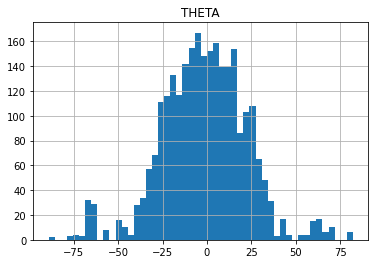

In [7]:
df.hist("THETA", bins=50)

from itertools import combinations
list(combinations([0,1,2,3,4,5,6,7,8,9], 4))